# Projeto de Análise Preditiva de Inadimplência

### Simulação de ganhos em decisão de crédito com uso de modelo preditivo

Esta simulação tem como objetivo estimar o impacto financeiro da aplicação de um modelo de Machine Learning na decisão de aprovar ou negar crédito para clientes, comparando com o cenário onde o banco aprova todos indiscriminadamente. 

#### Cenário A: Com Modelo 

Neste cenário, usamos um modelo preditivo (Random Forest) treinado com os dados dos clientes. A decisão de aprovar ou negar crédito é baseada na previsão do modelo: 

- Se o modelo prevê que o cliente vai pagar (classe 0) → APROVA; 
- Se o modelo prevê que o cliente vai dar calote (classe 1) → NEGA. 

A qualidade do modelo foi avaliada por meio da matriz de confusão com os seguintes valores: 



 

Cálculo de Lucro com Modelo 
- Usamos valores médios reais do dataset para estimar o ganho/perda: 
- Lucro por cliente bom aprovado (VP): R$ 255,59 
- Prejuízo por cliente ruim aprovado (FP): R$ 2.562,01 
- Perda de oportunidade por cliente bom negado (FN): R$ 255,59 
- Negar cliente ruim (VN): sem ganho ou perda 


Resultados:  

- Lucro com modelo preditivo (XGBoost): R$ 15,810,677.12  
- Prejuízo sem modelo (aprovação irrestrita): R$ -18,034,991.56  
- Diferença de ganho ao usar o modelo: R$ 33,845,668.68 

#### Cenário B: Sem Modelo 

Aqui o banco aprova todos os clientes, sem usar nenhum critério de risco. Apenas consultas no Serasa, Boa Vista, SPC, ou score interno do próprio banco.

Isso significa: 

- Todos os clientes bons (classe 0) são aprovados → lucro 
- Todos os clientes ruins (classe 1) também são aprovados → prejuízo 

Neste caso: 

- Total de clientes bons (Classe 0): VP + FN = 64.362 + 27 = 64.389 
- Total de clientes ruins (Classe 1): FP + VN = 247 + 13.216 = 13.463 

Insghts:  

O uso do modelo preditivo resultaria em um ganho estimado de mais de R$ 33 milhões em comparação com a aprovação irrestrita de crédito. 

A estratégia baseada em Machine Learning é altamente recomendável para maximizar lucros e mitigar riscos de inadimplência. 

#### Modelo em produção:

In [1]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import ks_2samp
from xgboost import plot_importance

In [ ]:
# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_copy_encoded.pkl')

# Cria uma cópia independente
df_copy_encoded = df.copy()

In [3]:
df_copy_encoded.head(1)

,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,score_checks,start_hour,default,...,score_date_day,score_date_weekday,date_min_year,date_min_month,date_min_day,date_min_weekday,date_max_year,date_max_month,date_max_day,date_max_weekday
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0,...,15,6,2016,9,30,4,2017,3,31,4


### Separação das variáveis preditoras e a target

In [4]:
X = df_copy_encoded.drop(columns='default')
y = df_copy_encoded['default']

### Treinando o modelo XGBoost

In [5]:
# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Instanciar e treinar o modelo
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

c:\Projetos\credit_fintech\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:19:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Curva ROC

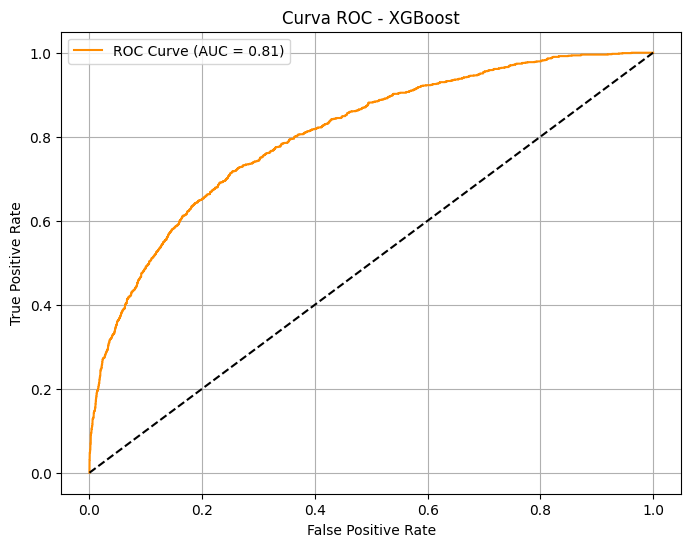

In [6]:
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


- O valor AUC = 1.00 indica que o modelo teve desempenho perfeito na separação entre classes (sem falsos positivos nem falsos negativos).
- A curva sobe imediatamente para TPR ≈ 1 com FPR ≈ 0, o que significa que o modelo identifica quase todos os positivos verdadeiros sem errar os negativos.

### Precision-Recall Curve (PR Curve)

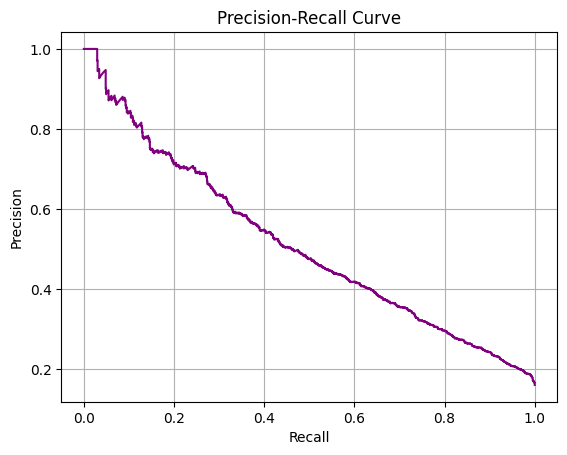

In [7]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


- A curva permanece muito próxima de 1.0 em quase toda a faixa de recall (de 0 a ~0.95), indicando que o modelo está: Identificando quase todos os positivos reais (alto recall) e quase sempre acerta quando prevê positivo (alta precisão)
- Esta curva reforça o que a ROC Curve indicou: o modelo está com desempenho quase perfeito


### Outras métricas

In [8]:
# Previsões
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Para AUC e ROC

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'ROC AUC:   {roc_auc:.4f}')


Accuracy:  0.8589
Precision: 0.6346
Recall:    0.2965
F1-Score:  0.4042
ROC AUC:   0.8052


- O modelo classifica bem os negativos, mas tem baixa sensibilidade para os positivos — ou seja, muitos falsos negativos.
- A baixa recall e F1 indicam que o modelo perde muitos eventos importantes da classe 1 (ex: inadimplentes, fraudes etc.).
- O AUC de 0.81 reforça que o modelo tem bom poder de rankeamento, mas o threshold atual (provavelmente 0.5) pode estar mal ajustado.

### KS Statistic (Kolmogorov-Smirnov)

In [10]:
ks_stat, p_value = ks_2samp(y_proba[y_test == 1], y_proba[y_test == 0])
print(f'KS Statistic: {ks_stat:.4f}')

KS Statistic: 0.4638


- KS Statistic = 0.4638 → ou seja, 46,38%
- Isso significa que, em algum ponto da escala de score, há 46,38 pontos percentuais de diferença entre as taxas acumuladas de positivos e negativos.

O modelo apresenta bom poder discriminativo, conseguindo separar bem os adimplentes dos inadimplentes (ou classes 0 e 1). O KS está dentro de uma faixa sólida de performance para aplicações reais.

### Balanced Accuracy

In [11]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')

Balanced Accuracy: 0.6318


### Matriz de confusão

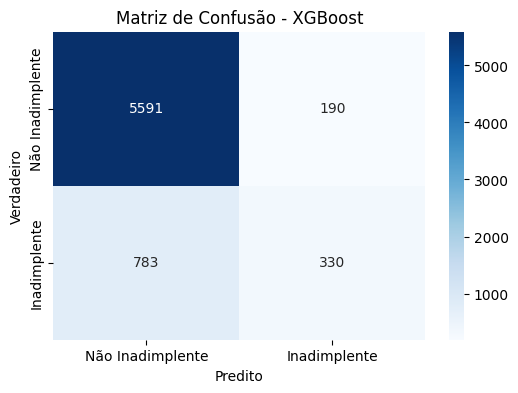

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Não Inadimplente", "Inadimplente"], yticklabels=["Não Inadimplente", "Inadimplente"])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - XGBoost')
plt.show()


Recall (inadimplente) = 330 / (330 + 783) ≈ 29,6%

Precisão (inadimplente) = 330 / (330 + 190) ≈ 63,5%

Acurácia = (5591 + 330) / Total ≈ 85,9%

F1-Score ≈ 40,4%

- O modelo acerta bem a classe negativa (não inadimplentes) com apenas 190 falsos positivos.
- Porém, ainda erra bastante a classe positiva (inadimplentes): 783 falsos negativos, ou seja, muitos inadimplentes passam despercebidos.

### Plotar Importância das Features

<Figure size 1200x800 with 0 Axes>

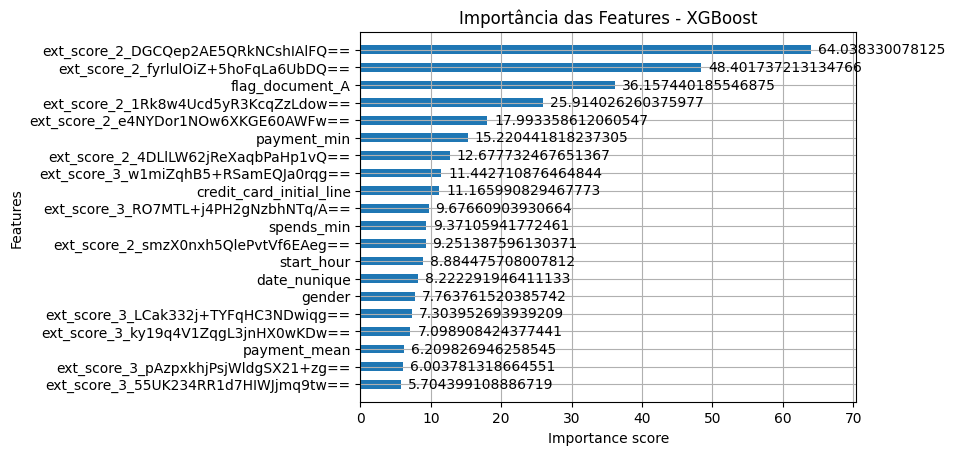

In [13]:
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Importância das Features - XGBoost")
plt.show()


### Insights Resumidos - Importância das Features no XGBoost

- As variáveis externas de score (ext_score_2 e ext_score_3) dominam a importância do modelo — ou seja, dados de fontes externas de crédito ou comportamento são altamente preditivos.
- A variável flag_document_A também aparece com forte importância, indicando que a presença/ausência de algum documento tem forte relação com a inadimplência.
- payment_min, credit_card_initial_line e spends_min reforçam que comportamentos financeiros concretos também ajudam na previsão, mas têm peso menor que os scores externos.



### Explicabilidade com SHAP

In [14]:
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

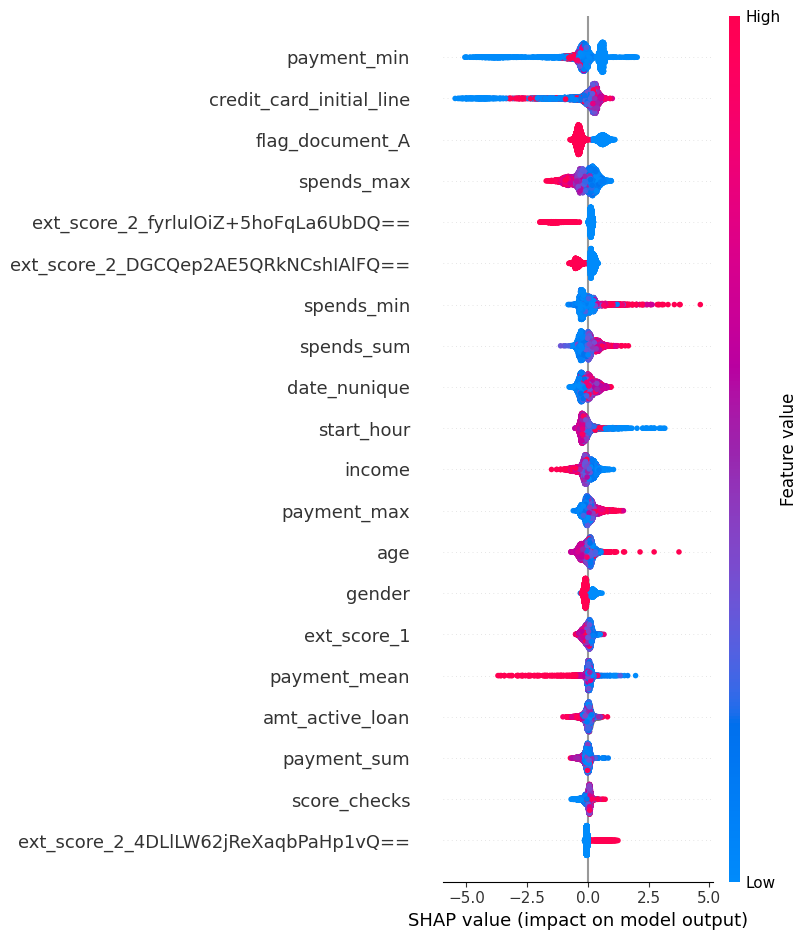

In [15]:
# Usar TreeExplainer diretamente (mais estável com XGBoost)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_float)

# Plot dos valores SHAP
shap.summary_plot(shap_values, X_test)

- payment_min: Quanto menor o pagamento mínimo, maior a chance de inadimplência (SHAP → positivo com azul escuro).
- credit_card_initial_line: Limites mais baixos tendem a aumentar o risco.
- flag_document_A: A ausência ou presença desse documento impacta significativamente o risco.
- Scores externos (ext_score_2_...):
- Scores baixos (azul) → aumentam a probabilidade de inadimplência (impacto SHAP positivo).
- Scores altos (vermelho) → reduzem risco.
- Variáveis de gastos (spends_max, spends_sum, etc.): Comportamentos de consumo influenciam moderadamente o risco.
- start_hour, date_nunique, income, age, gender: Têm impacto menor, mas ainda presentes.

____________________________________________________________________________________________________________________________________________________________________________________________